In [86]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import ROOT

In [87]:
file = ROOT.TFile.Open("../DetectorSimulation/Run0_t4.root")

In [88]:
hits = file.Get("hits")
hits.Print()

******************************************************************************
*Tree    :hits      : Energy deposit and position                            *
*Entries :      123 : Total =           14372 bytes  File  Size =       6617 *
*        :          : Tree compression factor =   1.00                       *
******************************************************************************
*Br    0 :Energy    : Double_t hits                                          *
*Entries :      123 : Total  Size=       2135 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :PositionX : Double_t hits                                          *
*Entries :      123 : Total  Size=       2150 bytes  One basket in memory    *
*Baskets :        0 : Basket Size=      32000 bytes  Compression=   1.00     *
*...................................................

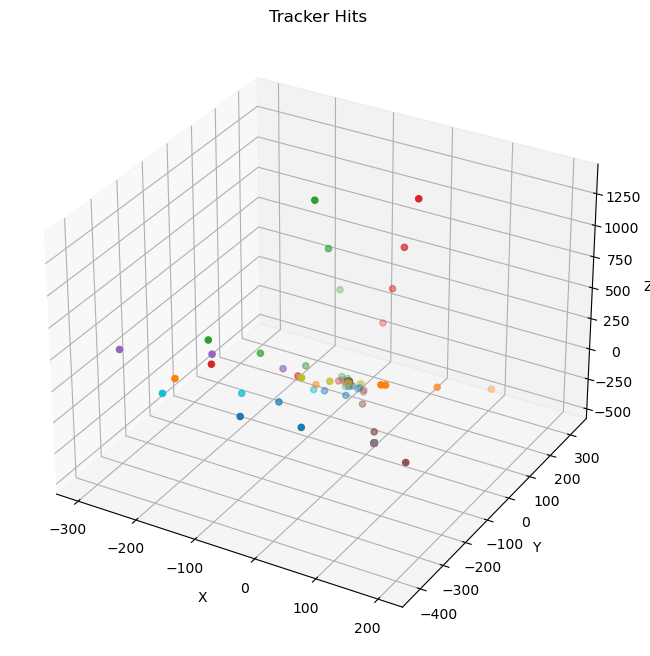

In [89]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

num_hits = hits.GetEntries()

x = np.zeros(num_hits)
y = np.zeros(num_hits)
z = np.zeros(num_hits)

tracks = {}

for i in range(num_hits):
    hits.GetEntry(i)
    x[i] = hits.PositionX
    y[i] = hits.PositionY
    z[i] = hits.PositionZ
    trackID = hits.TrackID
    if trackID not in tracks:
        tracks[trackID] = []
    tracks[trackID].append((hits.PositionX, hits.PositionY, hits.PositionZ))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Tracker Hits')

for track in tracks.values():
    x, y, z = zip(*track)
    ax.scatter(x, y, z)

plt.show()

# First we cheat and skip the track finding step, and simply fit tracks

In [90]:
for track in tracks:
    print(f"Track ID: {track}, Number of hits: {len(tracks[track])}")

Track ID: 25, Number of hits: 5
Track ID: 24, Number of hits: 4
Track ID: 22, Number of hits: 5
Track ID: 20, Number of hits: 4
Track ID: 94, Number of hits: 1
Track ID: 19, Number of hits: 5
Track ID: 114, Number of hits: 12
Track ID: 128, Number of hits: 12
Track ID: 18, Number of hits: 5
Track ID: 15, Number of hits: 5
Track ID: 14, Number of hits: 4
Track ID: 13, Number of hits: 4
Track ID: 10, Number of hits: 3
Track ID: 4, Number of hits: 4
Track ID: 1, Number of hits: 4
Track ID: 325, Number of hits: 37
Track ID: 351, Number of hits: 9


In [91]:
# Kasa method

def circle_fit(x, y):
    A = np.vstack([x, y, np.ones_like(x)]).T
    b = -(x*x + y*y)
    p, *_ = np.linalg.lstsq(A, b, rcond=None)
    A, B, C = p
    x_c = -A/2.0
    y_c = -B/2.0
    R = np.sqrt(x_c ** 2 + y_c ** 2 - C)
    return x_c, y_c, R

In [92]:
# compute sum over cross product of successive segments in xy

def curvature_sign(x, y):
    cross_z = 0.0
    for i in range(1, len(x) - 1):
        x1, y1 = x[i] - x[i-1], y[i] - y[i-1]
        x2, y2 = x[i+1] - x[i], y[i+1] - y[i]
        cross_z += x1 * y2 - y1 * x2
    return np.sign(cross_z) if cross_z != 0 else 1.0

In [ ]:
def fit_helix_and_sample(x, y, z, Bz=1.0, n_points=200, straight_thresh_R=1e6):
    xc, yc, R = circle_fit(x, y)

    # if radius is extremely large, fallback to straight-line fit
    if R > straight_thresh_R:
        A = np.vstack([z, np.ones_like(z)]).T
        ax, bx = np.linalg.lstsq(A, x, rcond=None)[0]
        ay, by = np.linalg.lstsq(A, y, rcond=None)[0]
        zmin, zmax = z.min(), z.max()
        zs_sample = np.linspace(zmin, zmax, n_points)
        xs_sample = ax*zs_sample + bx
        ys_sample = ay*zs_sample + by
        helix_pts = np.vstack([xs_sample, ys_sample, zs_sample]).T
        params = {'type':'line', 'ax':ax, 'ay':ay, 'bx':bx, 'by':by}
        return helix_pts, params

    sign = curvature_sign(x, y)

    angles = np.arctan2(y - yc, x - xc) 
    angles_unwrapped = np.unwrap(angles)

    phi0 = angles_unwrapped[0]
    s = R * (angles_unwrapped - phi0)  
    if len(s) >= 2:
        A = np.vstack([s, np.ones_like(s)]).T
        tanl, z0 = np.linalg.lstsq(A, z, rcond=None)[0]
    else:
        tanl = 0.0
        z0 = z[0]

    params = {'type':'helix', 'xc':xc, 'yc':yc, 'R':R, 'phi_ref':phi0, 'tanl':tanl, 'z_ref':z0, 'sign':sign}

    phi_min = angles_unwrapped.min()
    phi_max = angles_unwrapped.max()
    pad = 0.05 * (phi_max - phi_min if phi_max!=phi_min else 2*np.pi/n_points)
    phi_sample = np.linspace(phi_min - pad, phi_max + pad, n_points)

    s_sample = R * (phi_sample - phi0)
    z_sample = z0 + s_sample * tanl

    xs_sample = xc + R * np.cos(phi_sample)
    ys_sample = yc + R * np.sin(phi_sample)

    helix_pts = np.vstack([xs_sample, ys_sample, z_sample]).T
    return helix_pts, params

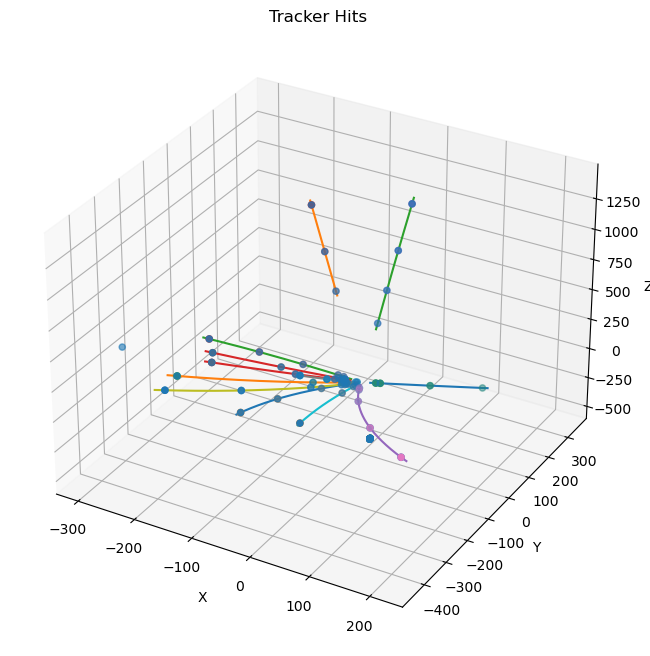

In [ ]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

num_hits = hits.GetEntries()

x = np.zeros(num_hits)
y = np.zeros(num_hits)
z = np.zeros(num_hits)

tracks = {}

for i in range(num_hits):
    hits.GetEntry(i)
    x[i] = hits.PositionX
    y[i] = hits.PositionY
    z[i] = hits.PositionZ
    trackID = hits.TrackID
    if trackID not in tracks:
        tracks[trackID] = []
    tracks[trackID].append((hits.PositionX, hits.PositionY, hits.PositionZ))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Tracker Hits')

for trackID, track in tracks.items():
    ax.scatter(x, y, z)
    if len(track) < 2:
        continue
    x, y, z = zip(*track)
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    helix_pts, params = fit_helix_and_sample(x, y, z, Bz=1.7)
    ax.plot(helix_pts[:,0], helix_pts[:,1], helix_pts[:,2])

plt.show()